# Mall Customer Segmentation and Forming Growth Strategy
by Kuanchieh Peng

## Dataset Overview
> The mall dataset contains information about customers such as customer_id, age, gender, annual income, and spending score.

## Problem Statement
> The goal is to increase customer lifetime value by segmenting customers into groups with similar characteristics and form growth strategies for each group.

## Steps
- **Imports**
    - Python lLibraries
    - Labeled Cellphone Accelerometer Dataset From Road Users
- **EDA & Preprocessing**
    - Cleaning
        - Handling outliers
        - Converting independent and dependent variables into desired data types
    - Transformation
        - Uninvariate displots and boxplots to spot skewness
    - Scaling
    - Checking Multicollinearity
        - Bivariate correlation heatmaps and pairplots to understand pairwise correlations
    - Checking Linear Separability
        - Training a hard margin linear SVC to test linear separability
- **Model Selection**
- **Evaluation Metric Selection**
- **Modeling**
    - Logistic Regression
        - CV and parameter optimization
    - XGBoost
        - CV and parameter optimization
- **Evaluation**
    - F-Beta Score
    - Prediction Speed
    - ROC curve (AUC)

## Sources
- Dataset is "Mobile Accelerometer Car 12K" from Kaggle.
- Background information derived from "City Safety, 2020 XC90 owner's manual" from Volvo.

## Imports

In [1]:
# for preprocessing
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# for visualizations
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# for modeling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import RepeatedStratifiedKFold

# for evaluation
from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
import time

# for suppressing system warnings
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = RuntimeWarning)

In [2]:
df = pd.read_csv('mall_customers.csv')
original_df = df.copy()

## Pipeline

In [3]:
class bold:
    start = '\033[1m'
    end   = '\033[0m'

def information(df):
    # Prints typically useful statistical information about given dataframe.
    print("This dataframe consists of ", df.shape[1], " columns and", df.shape[0], " rows.")
    print("This dataframe consists of ", df.isnull().sum().sum(), " null entires.")
    print("This dataframe consists of ", df[df.duplicated()].shape[0], " duplicate rows.")
    print("")
    print(bold.start, "Notable statistics of numeric features in this dataset:", bold.end)
    print("")
    print(df.describe())
    print("")
    print(bold.start, "Object type of features in this dataset:", bold.end)
    print("")
    df.info()
    
def pca_results(n_components, data):
    sc = StandardScaler()
    X = sc.fit_transform(data)
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    return pca, X_pca
    
def dist_box(x, title = ''):
    fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (14.4, 7.2))
    for ax in axes:
        sns.kdeplot(x, shade = False, ax = ax)
        kdeline = ax.lines[0]
        xs = kdeline.get_xdata()
        ys = kdeline.get_ydata()
        if ax == axes[0]:
            middle = x.mean()
            sdev = x.std()
            left = middle - sdev
            right = middle + sdev
            ax.set_title('Mean and SD')
        else:
            left, middle, right = np.percentile(x, [25, 50, 75])
            ax.set_title('Median and Quartiles')
        ax.vlines(middle, 0, np.interp(middle, xs, ys), ls = ':')
        ax.fill_between(xs, 0, ys, alpha = 0.2)
        ax.fill_between(xs, 0, ys, where = (left <= xs) & (xs <= right), interpolate = True, alpha = 0.2)
    fig.suptitle(title, fontsize = 16)
    plt.show()
    
def scree_plot(pca):
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
def three_d_scatter(df, target = 'target'):
    fig = plt.figure(figsize = (14.4, 10.8))
    ax = fig.add_subplot(111, projection = '3d')
    df_target1 = df[df[target] == 1]
    df_target0 = df[df[target] == 0]
    legend_properties = {}

    ax.scatter(df_target1['acc_x'], df_target1['acc_y'], df_target1['acc_z'], marker = 'x', label = 'Cars')
    ax.scatter(df_target0['acc_x'], df_target0['acc_y'], df_target0['acc_z'], marker = 'o', label = 'Non Cars')
    plt.legend(loc = 'best', prop = legend_properties)
    plt.show()

    
def logit_objective(space):
    clf = LogisticRegression(**params, random_state = 60, verbose = True)
    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 60)
    score = cross_val_score(clf, X_train, y_train, cv = cv, scoring = 'f1_macro')

    best_score = max(score)

    loss = 1 - best_score

    return {'loss': loss, 'params': params, 'status': STATUS_OK}

def xgb_objective(space):
    model = xgb.XGBClassifier(n_estimators = space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                         reg_alpha = int(space['reg_alpha']), min_child_weight = space['min_child_weight'],
                         colsample_bytree = space['colsample_bytree'])
    evaluation = [(X_train, y_train), (X_test, y_test)]
    
    model.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)

    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK, 'model': model}

def f_score(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = 1 - f1_score(y_true, np.round(y_pred))
    return 'f1_err', err
    
def evaluate(ytest, y_pred, speed):
    confusion = confusion_matrix(y_test, y_pred)
    fbeta = fbeta_score(y_test, y_pred, average = 'binary', beta = 1.2)
    print(bold.start, "Classification Report:", bold.end)
    print("")
    print(classification_report(y_test, y_pred))
    print(bold.start, "F - 1.2 Score:", bold.end)
    print("")
    print("{:.4f}".format(fbeta))
    print("")
    print(bold.start, "Prediction speed:", bold.end)
    print("")
    print("{:.4f} seconds".format(speed))
    
def roc(model_string, y_test, y_pred):
    roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.figure(figsize = (9.6, 7.2))
    plt.grid()
    plt.plot(fpr, tpr, label = model_string + ' (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc = "best")
    plt.show()

## Data Wrangling

In [7]:
df.head(3)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6


#### Assessment Report

In [8]:
information(df)

This dataframe consists of  5  columns and 200  rows.
This dataframe consists of  0  null entires.
This dataframe consists of  0  duplicate rows.

 Notable statistics of numeric features in this dataset: 

       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75%    150.250000   49.000000           78.000000               73.000000
max    200.000000   70.000000          137.000000               99.000000

 Object type of features in this dataset: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data column

- There are no missing values in the dataframe.
- The feature 'Gender' should be label encoded.
- The feature CustomerID can be dropped as the indeces serve its purpose.

#### Label Encoding

In [9]:
df = original_df.copy()
df.drop(['CustomerID'], axis = 1, inplace = True)

le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])

In [11]:
df.head(3)

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6


In [12]:
information(df)

This dataframe consists of  4  columns and 200  rows.
This dataframe consists of  0  null entires.
This dataframe consists of  0  duplicate rows.

 Notable statistics of numeric features in this dataset: 

           Gender         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean     0.440000   38.850000           60.560000               50.200000
std      0.497633   13.969007           26.264721               25.823522
min      0.000000   18.000000           15.000000                1.000000
25%      0.000000   28.750000           41.500000               34.750000
50%      0.000000   36.000000           61.500000               50.000000
75%      1.000000   49.000000           78.000000               73.000000
max      1.000000   70.000000          137.000000               99.000000

 Object type of features in this dataset: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data column

## EDA
Calculate and visualize correlation between variables. Check for multicollineraity.

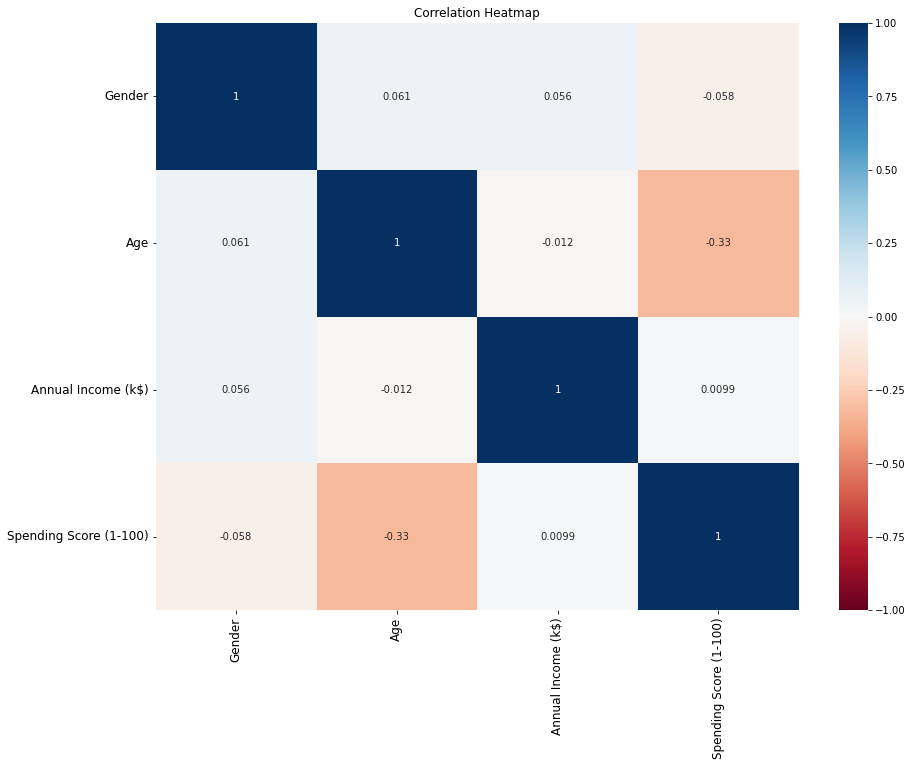

In [13]:
plt.figure(figsize = (14.4, 10.8))
plot1 = sns.heatmap(df.corr(), annot = True, cmap = 'RdBu', vmin = -1, vmax = 1, center = 0)
plot1.set_yticklabels(plot1.get_yticklabels(), rotation = 0, fontsize = 12)
plot1.set_xticklabels(plot1.get_xticklabels(), rotation = 90, fontsize = 12)
plt.title("Correlation Heatmap")
plt.savefig("correlation.png",bbox_inches='tight')
plt.show()
#plot1.savefig('plot1.png', dpi = 400)

Age and spending score are the most correlated, with correlation coefficient -0.33.

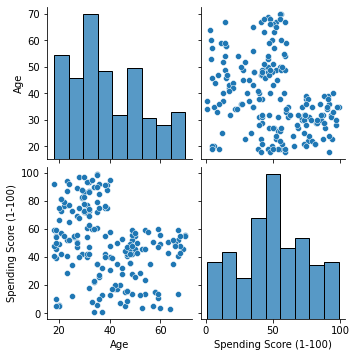

In [14]:
plot2 = sns.pairplot(df[['Age', 'Spending Score (1-100)']])
#plot2.savefig('plot2.png', dpi = 400)

#### Principal Component Analysis
Drop feature 'Gender' since PCA is designed for continuous variables. Then conduct PCA for distribution in 2D to discover potential clusters.

In [15]:
df_before_pca = df.copy()
df.drop(['Gender'], axis = 1, inplace = True)

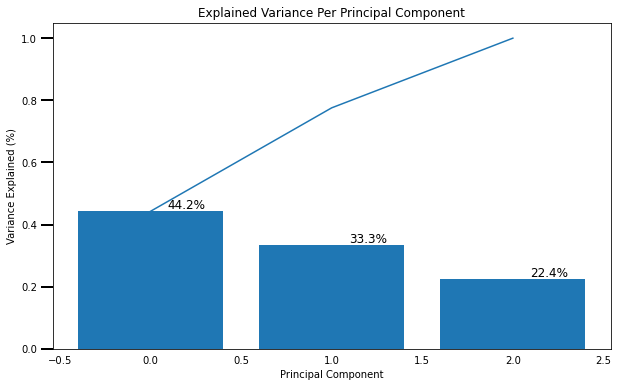

In [16]:
sc = StandardScaler()
df_transformed = sc.fit_transform(df)

pca, X_pca = pca_results(3, df_transformed)
scree_plot(pca)

According to the above, if we plot the distribution with PC1 and PC2, we only capture around 77.5% variance of the data.

Text(0, 0.5, 'component 2')

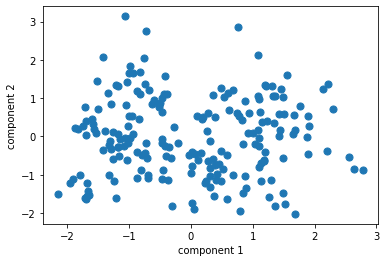

In [12]:
pca, X_pca = pca_results(2, df_transformed)
plt.scatter(X_pca[:,0], X_pca[:, 1], s = 50)
plt.xlabel('component 1')
plt.ylabel('component 2')

The number of clusters can hardly be told. There seems to be four clusters distributed in a slightly uneven matter.

#### Clustering Analysis

C:\Users\taan7\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


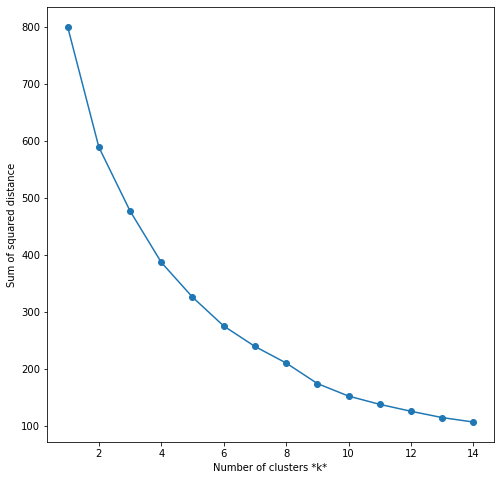

In [13]:
# using Elbow Method 

# Run the Kmeans algorithm and get the index of data points clusters
from sklearn.cluster import KMeans
sse = []
list_k = list(range(1, 15))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(df_transformed)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(8, 8))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');
plt.savefig("elbow.png",bbox_inches='tight')

There is no clear elbow, a certain point where the amount of information added diminishes. Try Silhouette index to find optimal k.

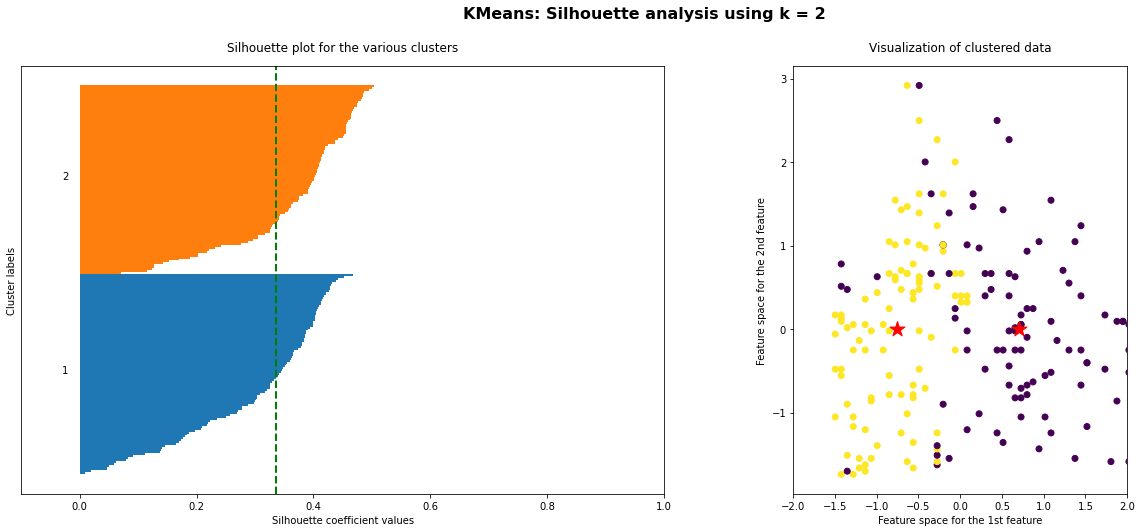

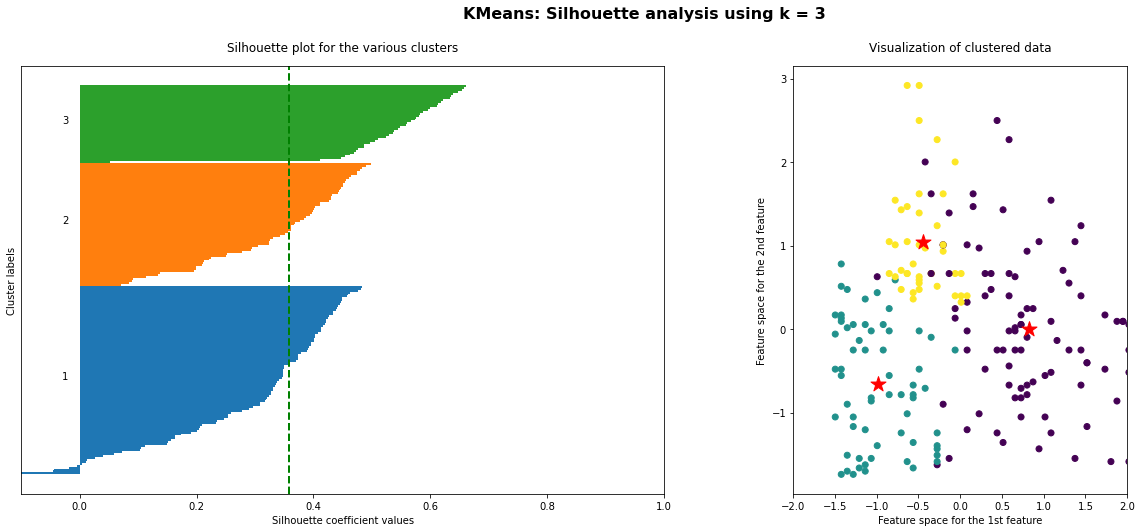

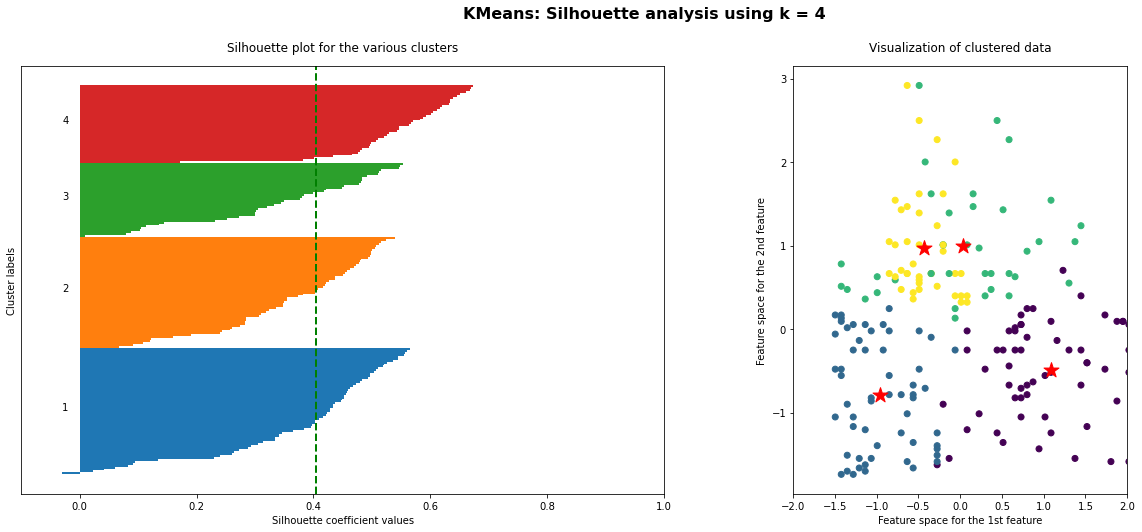

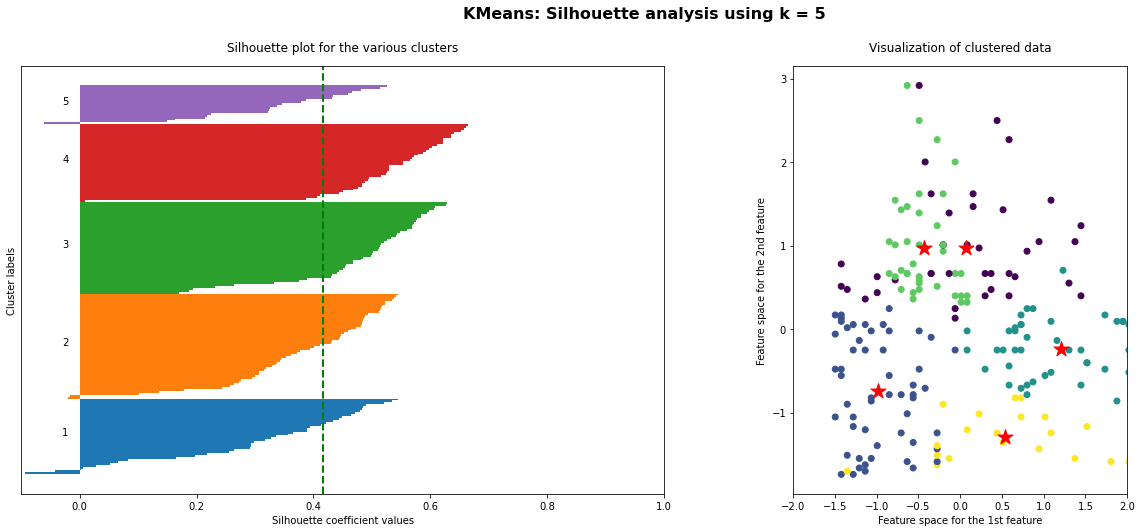

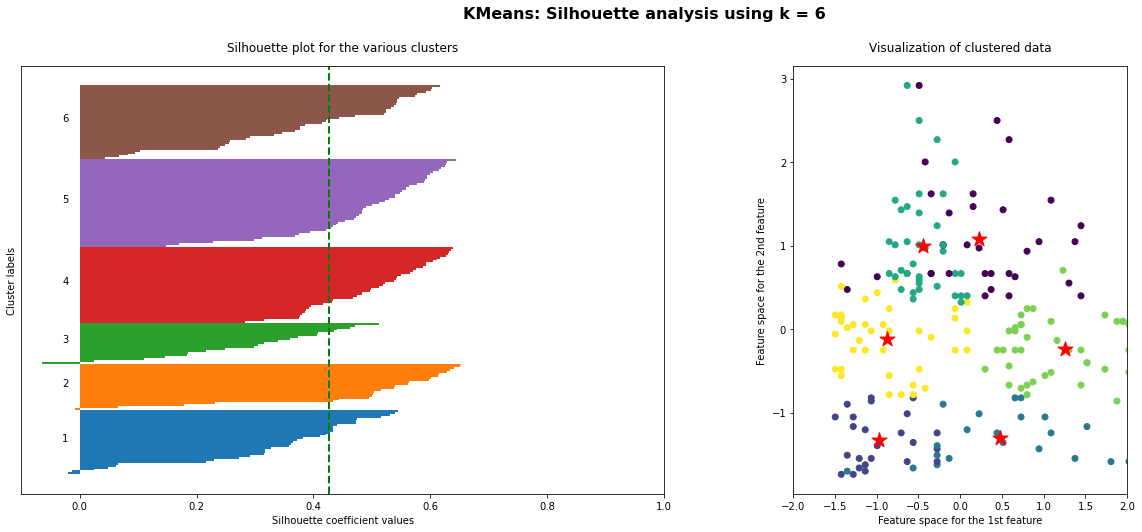

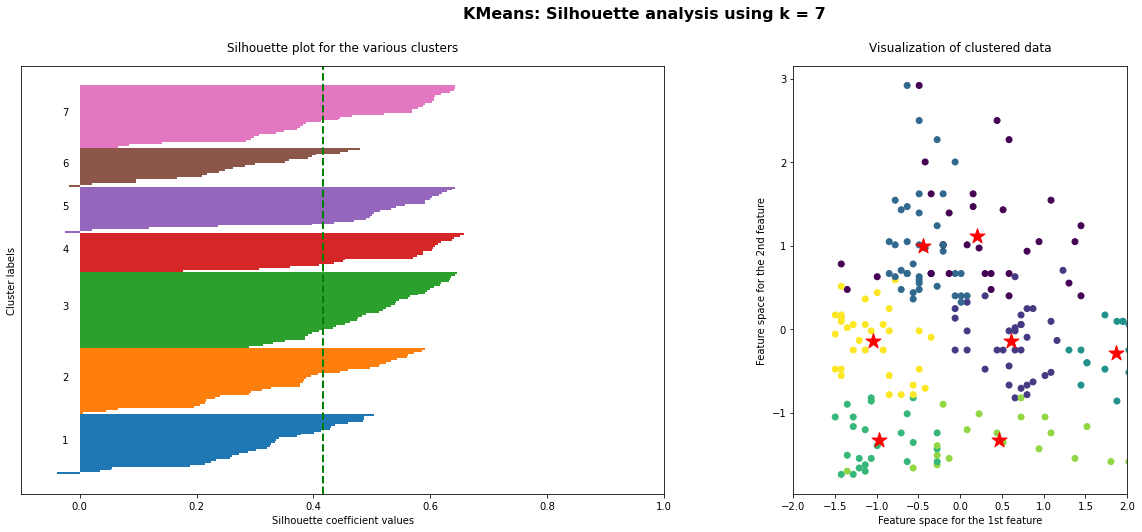

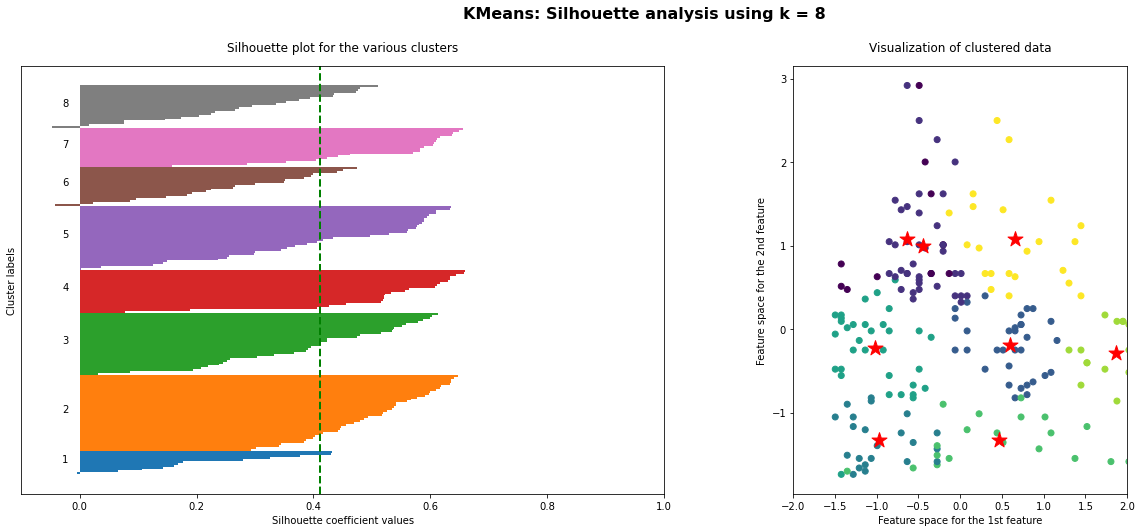

In [19]:
# Silhouette index method
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score

for i, k in enumerate([2, 3, 4, 5, 6, 7, 8]):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(df_transformed)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(df_transformed, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);
    
    # Scatter plot of data colored with labels
    ax2.scatter(df_transformed[:, 0], df_transformed[:, 1], c=labels)
    ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    ax2.set_xlim([-2, 2])
    ax2.set_xlim([-2, 2])
    ax2.set_xlabel('Feature space for the 1st feature')
    ax2.set_ylabel('Feature space for the 2nd feature')
    ax2.set_title('Visualization of clustered data', y=1.02)
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'KMeans: Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);

k = 6 is where the highest average Sihouette score, 0.42 (refer to the vertical green dotted line), occurs.

## Model Selection
>We want to prioritize getting the best **classification accuracy on unknown data** and  **classification speed**. We can sacrifice training speed and interpretability of the model since the model will be used by vehicles on roads in real time.

>The entire dataset consists of 3 continuous feature columns, 1 categorical target column, and 120,000 rows. That is, we have a **small feature set** and a **large dataset**. There are no missing or questionable values in the dataset. The distribution of the transformed three variables are still slightly **skewed** left, right, and right in the order acc_x, acc_y, and acc_z. There are **no outliers** in any of the three. Data of the two classes are **linearly separable.**

I will use **logistic regression** as my baseline model. The reasons I think logistic regression would serve as a great baseline model in this project are:
1. It is efficient to train.
2. It tends to work well andnot overfit with low dimensional datasets like ours.
3. Works since our dataset is linearly separable.

I will use **XGBoost** as my expected best performing model. The reasons I think XGBoost is the better choice over other boosting and bagging algorithms such as random forest are:
1. Much better prediction speed compared to bagging algorithms.
2. Great accuracy performance as it pushes the limit of computation resources for boosted tree algorithms.
3. Sophisticated but not prone to overfitting as long as parameters are tuned properly.
4. Handles large datasets well.
5. Difficult to interpret but we can sacrifice interpretability thanks to the background of this project.

Then, I will use SGD for optimization because:
1. We have a large amount of data.

## Evaluation Metric selection
Accuracy is one of our two main concerns. According to our background information, **avoiding type II errors is more important** than avoiding type I error, while we want to avoid both. Therefore, I will use F-beta score with beta = 1.2 to evaluate the accuracy performance of our model.

Prediction speed is the other main concern. I will use pandas library "time" to assess the prediction speed performance of our model.

## Logistic Regression

### Feature Selection
- Reminder: The correlation between acc_y and acc_z is -0.6. Might have to remove one of the two variables to make sure the model has little to no multicollinearity (one of the assumptions of logistic regression).

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df[{'acc_x', 'acc_y', 'acc_z'}],
                                                   df['target'],
                                                   test_size = 0.2,
                                                   random_state = 60)

In [21]:
X_train['intercept'] = 1
logit = sm.Logit(y_train, X_train)
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.196854
         Iterations 9


In [22]:
X_train = X_train.drop('intercept', axis = 1)
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.716     
Dependent Variable: target           AIC:              37803.8907
Date:               2021-12-12 15:54 BIC:              37841.7791
No. Observations:   96000            Log-Likelihood:   -18898.   
Df Model:           3                LL-Null:          -66542.   
Df Residuals:       95996            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     9.0000                                       
-----------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
-----------------------------------------------------------------
acc_z         -14.9531   0.9694 -15.4257 0.0000 -16.8530 -13.0532
acc_y          50.7195   0.5457  92.9398 0.0000  49.6499  51.7891
acc_x           0.2558   0.1854   1.3795 0.1677  -0.1076   0.6193
intercept     -34.8589   0.7069 -49.3130 0.0000 -36.2444 -33.4734
=================================================================

"""

- acc_x has p-value of 0.276 > 0.05. Remove acc_x from our feature set.

In [23]:
X_train_logit = X_train.drop('acc_x', axis = 1)
X_test_logit = X_test.drop('acc_x', axis = 1)

### Fitting the Model

In [24]:
logit = LogisticRegression()
logit.fit(X_train_logit, y_train)

LogisticRegression()

In [25]:
print("Training accuracy: {:.4f}".format(logit.score(X_train_logit, y_train)))

Training accuracy: 0.9287


In [26]:
temp = X_test.drop('acc_x', axis = 1)
#########
start_time = time.time()
logit_y_pred = logit.predict(temp)
logit_speed = time.time() - start_time
#########
del temp

print("Prediction Accuracy: {:.4f}".format(logit.score(X_test_logit, y_test)))

Prediction Accuracy: 0.9297


## XGBoost

### Fitting the Model

In [29]:
dmtrain = xgb.DMatrix(X_train, label = y_train)
dmtest  = xgb.DMatrix(X_test, label = y_test)

In [60]:
xgb_params = { 
    'max_depth': [3,6,10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500, 1000],
    'colsample_bytree': [0.3, 0.7]
}

In [65]:
xgbc = xgb.XGBClassifier(seed = 60)
clf = GridSearchCV(estimator = xgbc, 
                   param_grid = xgb_params,
                   scoring = 'neg_mean_squared_error', 
                   verbose = 1)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed: 32.9min finished


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=60,
                                     subsample=None, tree_method=None,
         

In [66]:
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Best parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000}
Lowest RMSE:  0.1924621174846278


In [69]:
xgbc = xgb.XGBClassifier(n_estimators = 1000, learning_rate = 0.1, colsample_bytree = 0.3, max_depth = 10)
xgbc.fit(X_train, y_train)
acc_xgboost = xgbc.score(X_test, y_test)

XGBoost:  0.965


In [74]:
#########
start_time = time.time()
xgbc_y_pred = xgbc.predict(X_test)
xgbc_speed = time.time() - start_time
#########

print("Prediction Accuracy: {:.4f}".format(xgbc.score(X_test, y_test)))

Prediction Accuracy: 0.9650


## Evaluation

In [84]:
### logistic regression classifier ###
evaluate(y_test, logit_y_pred, logit_speed)

 Classification Report: 

              precision    recall  f1-score   support

         0.0       0.96      0.90      0.93     11992
         1.0       0.90      0.96      0.93     12008

    accuracy                           0.93     24000
   macro avg       0.93      0.93      0.93     24000
weighted avg       0.93      0.93      0.93     24000

 F - 1.2 Score: 

0.9369

 Prediction speed: 

0.0030 seconds


In [85]:
### tree XGBooster ###
evaluate(y_test, xgbc_y_pred, xgbc_speed)

 Classification Report: 

              precision    recall  f1-score   support

         0.0       0.98      0.95      0.96     11992
         1.0       0.95      0.98      0.97     12008

    accuracy                           0.96     24000
   macro avg       0.97      0.96      0.96     24000
weighted avg       0.97      0.96      0.96     24000

 F - 1.2 Score: 

0.9675

 Prediction speed: 

0.2769 seconds


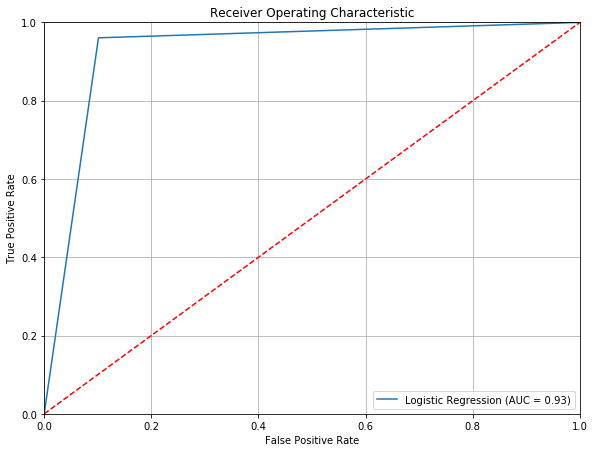

In [86]:
### logistic regression classifier ###
roc('Logistic Regression', y_test, logit_y_pred)

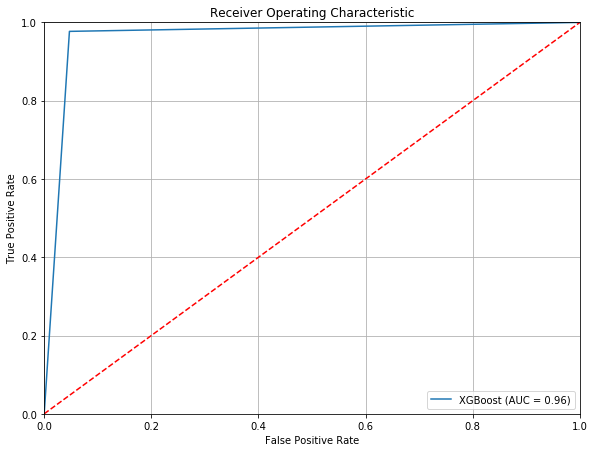

In [87]:
### tree XGBooster ###
roc('XGBoost', y_test, xgbc_y_pred)

## Summary

The logistic regression classifier has the better prediction speed by .274 seconds, the speeds .2769 compared to .0030. However, the XGBooster has the better F-1.2 score, the scores .9675 compared to .9369.

Although .274 seeconds is a considerable improvement in prediction speed, .2769 is already an acceptable prediction speed since this model is not used to predict as late as when the road user is already right in front of the car. Therefore, the XGBoost classifier will be the final model choice to solve the problem in this project.